In [1]:
!pip install -qU openimages torch_snippets urllib3

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [2]:
!wget -O open_images_train_captions.jsonl -q https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.jsonl

In [3]:
from torch_snippets import *

In [4]:
!pip install torch

In [5]:
pip install lovely-tensors

In [6]:
from torch_snippets import *

In [7]:
import json

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
with open('open_images_train_captions.jsonl', 'r') as json_file:
 json_list = json_file.read().split('\n')
np.random.shuffle(json_list)
data = []
N = 100000
for ix, json_str in Tqdm(enumerate(json_list), N):
 if ix == N: break
 try:
  result = json.loads(json_str)
  x = pd.DataFrame.from_dict(result, orient='index').T
  data.append(x)
 except:
  pass

100%|██████████| 100000/100000 [01:02<00:00, 1604.33it/s]


In [10]:
np.random.seed(10)
data = pd.concat(data)
data['train'] = np.random.choice([True,False], size=len(data),p=[0.95,0.05])
data.to_csv('data.csv', index=False)

In [11]:
from openimages.download import _download_images_by_id

In [12]:
!mkdir -p train-images val-images

In [13]:
subset_imageIds = data[data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './train-images/')

100%|██████████| 95044/95044 [23:30<00:00, 67.39it/s]


In [14]:
subset_imageIds = data[~data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './val-images/')


100%|██████████| 4956/4956 [01:13<00:00, 67.34it/s]


In [15]:
pip install -U torchtext==0.6

In [16]:
from torchtext.data import Field
from pycocotools.coco import COCO
from collections import defaultdict

In [17]:
captions = Field(sequential=False, init_token='<start>', eos_token='<end>')
all_captions = data[data['train']]['caption'].tolist()
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]
all_tokens = [w for sublist in all_tokens for w in sublist]
captions.build_vocab(all_tokens)

In [18]:
class Vocab: pass
vocab = Vocab()
captions.vocab.itos.insert(0, '<pad>')
vocab.itos = captions.vocab.itos
vocab.stoi = defaultdict(lambda: captions.vocab.itos.index('<unk>'))
vocab.stoi['<pad>'] = 0
for s,i in captions.vocab.stoi.items():
 vocab.stoi[s] = i+1

In [30]:
from torchvision import transforms
class CaptioningData(Dataset):
 def __init__(self, root, df, vocab):
  self.df = df.reset_index(drop=True)
  self.root = root
  self.vocab = vocab
  self.transform = transforms.Compose([
  transforms.Resize(224),
  transforms.RandomCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406),
  (0.229, 0.224, 0.225))]
  )
 def __getitem__(self, index):
  """Returns one data pair (image and caption)."""
  row = self.df.iloc[index].squeeze()
  id = row.image_id
  image_path = f'{self.root}/{id}.jpg'
  image = Image.open(os.path.join(image_path)).convert('RGB')
  caption = row.caption
  tokens = str(caption).lower().split()
  target = []
  target.append(vocab.stoi['<start>'])
  target.extend([vocab.stoi[token] for token in tokens])
  target.append(vocab.stoi['<end>'])
  target = torch.Tensor(target).long()
  return image, target, caption
 def choose(self):
  return self[np.random.randint(len(self))]
 def __len__(self):
  return len(self.df)
 def collate_fn(self, data):
  data.sort(key=lambda x: len(x[1]), reverse=True)
  images, targets, captions = zip(*data)
  images = torch.stack([self.transform(image) for image in images], 0)
  lengths = [len(tar) for tar in targets]
  _targets = torch.zeros(len(captions), max(lengths)).long()
  for i, tar in enumerate(targets):
    end = lengths[i]
    _targets[i, :end] = tar[:end]
  return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)

In [20]:
# def __getitem__(self, index):
#  """Returns one data pair (image and caption)."""
#  row = self.df.iloc[index].squeeze()
#  id = row.image_id
#  image_path = f'{self.root}/{id}.jpg'
#  image = Image.open(os.path.join(image_path)).convert('RGB')
#  caption = row.caption
#  tokens = str(caption).lower().split()
#  target = []
#  target.append(vocab.stoi['<start>'])
#  target.extend([vocab.stoi[token] for token in tokens])
#  target.append(vocab.stoi['<end>'])
#  target = torch.Tensor(target).long()
#  return image, target, caption

In [21]:
# def choose(self):
#  return self[np.random.randint(len(self))]

In [22]:
# def __len__(self):
#  return len(self.df)

In [23]:
# def collate_fn(self, data):
#  data.sort(key=lambda x: len(x[1]), reverse=True)
#  images, targets, captions = zip(*data)
#  images = torch.stack([self.transform(image) for image in images], 0)
#  lengths = [len(tar) for tar in targets]
#  _targets = torch.zeros(len(captions), max(lengths)).long()
#  for i, tar in enumerate(targets):
#   end = lengths[i]
#   _targets[i, :end] = tar[:end]
#  return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)

In [31]:
trn_ds = CaptioningData('train-images', data[data['train']], vocab)
val_ds = CaptioningData('val-images', data[~data['train']], vocab)


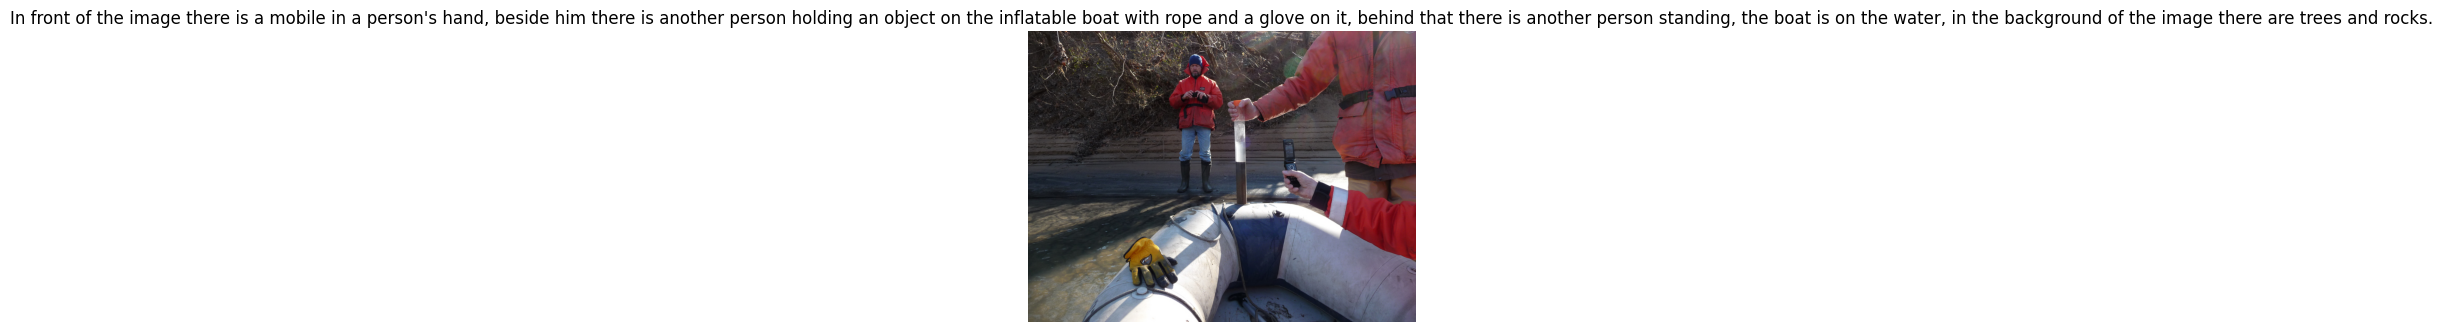

tensor[59] i64 x∈[2, 1942] μ=142.085 σ=341.946

In [32]:
image, target, caption = trn_ds.choose()
show(image, title=caption, sz=5); print(target)

In [33]:
trn_dl = DataLoader(trn_ds, 32, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, collate_fn=val_ds.collate_fn)
inspect(*next(iter(trn_dl)), names='images,targets,lengths')

══════════════════════════════════════════════════════════════════

tensor[32, 3, 224, 224] n=4816896 (18Mb) x∈[-2.118, 2.640] μ=-0.255 σ=1.239

══════════════════════════════════════════════════════════════════

tensor[32, 70] i64 n=2240 (18Kb) x∈[0, 13899] μ=82.178 σ=530.791

══════════════════════════════════════════════════════════════════

tensor[32] i64 x∈[13, 70] μ=31.438 σ=15.442

══════════════════════════════════════════════════════════════════

In [48]:
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
class EncoderCNN(nn.Module):
 def __init__(self, embed_size):
  """Load the pretrained ResNet-152 and replace
  top fc layer."""
  super(EncoderCNN, self).__init__()
  resnet = models.resnet152(pretrained=True)
  # delete the last fc layer.
  modules = list(resnet.children())[:-1]
  self.resnet = nn.Sequential(*modules)
  self.linear = nn.Linear(resnet.fc.in_features, embed_size)
  self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
 def forward(self, images):
  """Extract feature vectors from input images."""
  with torch.no_grad():
    features = self.resnet(images)
  features = features.reshape(features.size(0), -1)
  features = self.bn(self.linear(features))
  return features

In [49]:
encoder = EncoderCNN(256).to(device)
!pip install torch_summary


In [50]:
pip install torchsummary

In [51]:
from torchsummary import summary
print(summary(encoder,torch.zeros(32,3,224,224).to(device)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28] 

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-7              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-8              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-9              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-10             [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-11             [-1, 512, 28, 28]         280,064
|    └─Sequential: 2-7                   [-1, 1024, 14, 14]        --
|    |    └─Bottleneck: 3-12             [-1, 1024, 14, 14]        1,512,448
|    |    └─Bottleneck: 3-13             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-14             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-15             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-16             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-17             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-18             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-19             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-20             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-21             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-22             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-23             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-24             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-25             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-26             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-27             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-28             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-29             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-30             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-31             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-32             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-33             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-34             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-35             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-36             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-37             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-38             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-39             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-40             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-41             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-42             [-1, 1

In [75]:
class DecoderRNN(nn.Module):
 def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):
  """Set the hyper-parameters and build the layers."""
  super(DecoderRNN, self).__init__()
  self.embed = nn.Embedding(vocab_size, embed_size)
  self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
  self.linear = nn.Linear(hidden_size, vocab_size)
  self.max_seq_length = max_seq_length

 def forward(self, features, captions, lengths):
  """Decode image feature vectors and
  generates captions."""
  embeddings = self.embed(captions)
  embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
  packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True)
  outputs, _ = self.lstm(packed)
  outputs = self.linear(outputs[0])
  return outputs
 def predict(self, features, states=None):
  """Generate captions for given image
  features using greedy search."""
  sampled_ids = []
  inputs = features.unsqueeze(1)
  for i in range(self.max_seq_length):
    hiddens, states = self.lstm(inputs, states)
    # hiddens: (batch_size, 1, hidden_size)
    outputs = self.linear(hiddens.squeeze(1))
    # outputs: (batch_size, vocab_size)
    _, predicted = outputs.max(1)
    # predicted: (batch_size)
    sampled_ids.append(predicted)
    inputs = self.embed(predicted)
    # inputs: (batch_size, embed_size)
    inputs = inputs.unsqueeze(1)
    # inputs: (batch_size, 1, embed_size)
  sampled_ids = torch.stack(sampled_ids, 1)
  # sampled_ids: (batch_size, max_seq_length)
  # convert predicted tokens to strings
  sentences = []
  for sampled_id in sampled_ids:
    sampled_id = sampled_id.cpu().numpy()
    sampled_caption = []
    for word_id in sampled_id:
      word = vocab.itos[word_id]
      sampled_caption.append(word)
      if word == '<end>':
        break
    sentence = ' '.join(sampled_caption)
    sentences.append(sentence)
  return sentences
 def train_batch(self,data, encoder, decoder, optimizer, criterion):
  encoder.train()
  decoder.train()
  images, captions, lengths = data
  images = images.to(device)
  captions = captions.to(device)
  targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
  features = encoder(images)
  outputs = decoder(features, captions, lengths)
  loss = criterion(outputs, targets)
  decoder.zero_grad()
  encoder.zero_grad()
  loss.backward()
  optimizer.step()
  return loss
 @torch.no_grad()
 def validate_batch(self,data, encoder, decoder, criterion):
  encoder.eval()
  decoder.eval()
  images, captions, lengths = data
  images = images.to(device)
  captions = captions.to(device)
  targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
  features = encoder(images)
  outputs = decoder(features, captions, lengths)
  loss = criterion(outputs, targets)
  return loss
#  def load_image(self,image_path, transform=None):
#   image = Image.open(image_path).convert('RGB')
#   image = image.resize([224, 224], Image.LANCZOS)
#   if transform is not None:
#    tfm_image = transform(image)[None]
#   return image, tfm_image
#  def load_image_and_predict(self,image_path):
#   transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),  (0.229, 0.224, 0.225)) ])
#   org_image, tfm_image = load_image(image_path, transform)
#   image_tensor = tfm_image.to(device)
#   encoder.eval()
#   decoder.eval()
#   feature = encoder(image_tensor)
#   sentence = decoder.predict(feature)[0]
#   show(org_image, title=sentence)
#   return sentence
#  files = Glob('val-images')
#  load_image_and_predict(choose(files))

In [ ]:
#  def load_image(image_path, transform=None):
#   image = Image.open(image_path).convert('RGB')
#   image = image.resize([224, 224], Image.LANCZOS)
#   if transform is not None:
#     tfm_image = transform(image)[None]
#     return image, tfm_image
#  def load_image_and_predict(image_path):
#   transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),  (0.229, 0.224, 0.225)) ])
#   org_image, tfm_image = load_image(image_path, transform)
#   image_tensor = tfm_image.to(device)
#   encoder.eval()
#   decoder.eval()
#   feature = encoder(image_tensor)
#   sentence = decoder.predict(feature)[0]
#   show(org_image, title=sentence)
#   return sentence
#  files = Glob('val-images')
#  load_image_and_predict(choose(files))

In [63]:
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.AdamW(params, lr=1e-3)
n_epochs = 10
log = Report(n_epochs)
for epoch in range(n_epochs):
 if epoch == 5: optimizer = torch.optim.AdamW(params, lr=1e-4)
 N = len(trn_dl)
 for i, data in enumerate(trn_dl):
   trn_loss = decoder.train_batch(data, encoder, decoder, optimizer, criterion)
   pos = epoch + (1+i)/N
   log.record(pos=pos, trn_loss=trn_loss, end='\r')
 N = len(val_dl)
 for i, data in enumerate(val_dl):
  val_loss = decoder.validate_batch(data, encoder, decoder, criterion)
  pos = epoch + (1+i)/N
  log.record(pos=pos, val_loss=val_loss, end='\r')
 log.report_avgs(epoch+1)
log.plot_epochs(log=True)

EPOCH: 0.060  trn_loss: 2.850  (4115.49s - 682801.80s remaining)

KeyboardInterrupt: ignored

100%|██████████| 111/111 [00:00<00:00, 11151.06it/s]


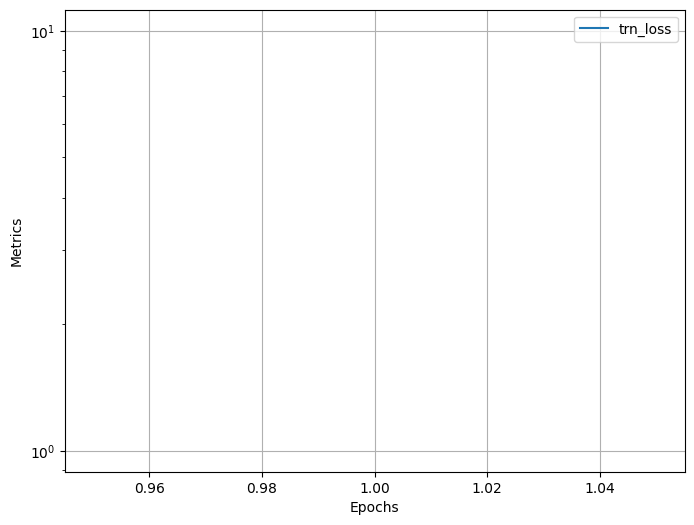

In [84]:
log.plot_epochs(log=True)

In [79]:
# decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)

In [82]:
def load_image(self,image_path, transform=None):
  image = Image.open(image_path).convert('RGB')
  image = image.resize([224, 224], Image.LANCZOS)
  if transform is not None:
   tfm_image = transform(image)[None]
  return image, tfm_image
def load_image_and_predict(image_path):
  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),  (0.229, 0.224, 0.225)) ])
  org_image, tfm_image = load_image(image_path, transform)
  image_tensor = tfm_image.to(device)
  encoder.eval()
  decoder.eval()
  feature = encoder(image_tensor)
  sentence = decoder.predict(feature)[0]
  show(org_image, title=sentence)
  return sentence

In [86]:
from torchvision import transforms

In [87]:
files = Glob('val-images')
load_image_and_predict(choose(files))

AttributeError: ignored

In [ ]:
# def predict(self, features, states=None):
#  """Generate captions for given image
#  features using greedy search."""
#  sampled_ids = []
#  inputs = features.unsqueeze(1)
#  for i in range(self.max_seq_length):
#   hiddens, states = self.lstm(inputs, states)
#   # hiddens: (batch_size, 1, hidden_size)
#   outputs = self.linear(hiddens.squeeze(1))
#   # outputs: (batch_size, vocab_size)
#   _, predicted = outputs.max(1)
#   # predicted: (batch_size)
#   sampled_ids.append(predicted)
#   inputs = self.embed(predicted)
#   # inputs: (batch_size, embed_size)
#   inputs = inputs.unsqueeze(1)
#   # inputs: (batch_size, 1, embed_size)
#  sampled_ids = torch.stack(sampled_ids, 1)
#  # sampled_ids: (batch_size, max_seq_length)
#  # convert predicted tokens to strings
#  sentences = []
#  for sampled_id in sampled_ids:
#   sampled_id = sampled_id.cpu().numpy()
#   sampled_caption = []
#   for word_id in sampled_id:
#     word = vocab.itos[word_id]
#     sampled_caption.append(word)
#     if word == '<end>':
#       break
#   sentence = ' '.join(sampled_caption)
#   sentences.append(sentence)
#  return sentences

In [ ]:
# def train_batch(data, encoder, decoder, optimizer, criterion):
#  encoder.train()
#  decoder.train()
#  images, captions, lengths = data
#  images = images.to(device)
#  captions = captions.to(device)
#  targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
#  features = encoder(images)
#  outputs = decoder(features, captions, lengths)
#  loss = criterion(outputs, targets)
#  decoder.zero_grad()
#  encoder.zero_grad()
#  loss.backward()
#  optimizer.step()
#  return loss

In [ ]:
# @torch.no_grad()
# def validate_batch(data, encoder, decoder, criterion):
#  encoder.eval()
#  decoder.eval()
#  images, captions, lengths = data
#  images = images.to(device)
#  captions = captions.to(device)
#  targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
#  features = encoder(images)
#  outputs = decoder(features, captions, lengths)
#  loss = criterion(outputs, targets)
#  return loss

In [43]:
# encoder = EncoderCNN(256).to(device)
# decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)
# criterion = nn.CrossEntropyLoss()
# params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
# optimizer = torch.optim.AdamW(params, lr=1e-3)
# n_epochs = 10
# log = Report(n_epochs)

In [85]:
# for epoch in range(n_epochs):
#  if epoch == 5: optimizer = torch.optim.AdamW(params, lr=1e-4)
#  N = len(trn_dl)
#  for i, data in enumerate(trn_dl):
#   trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
#   pos = epoch + (1+i)/N
#   log.record(pos=pos, trn_loss=trn_loss, end='\r')
#   N = len(val_dl)
#   for i, data in enumerate(val_dl):
#     val_loss = validate_batch(data, encoder, decoder, criterion)
#     pos = epoch + (1+i)/N
#     log.record(pos=pos, val_loss=val_loss, end='\r')
#     log.report_avgs(epoch+1)
# log.plot_epochs(log=True)